In [82]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn import config

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

class SolarDataset(utils.Dataset):
    def load_dataset(self, dataset_dir, dataset_type='train'):
        """
        Load the dataset from the specified directory and dataset type (train, val, test).
        """
        # Register the classes
        self.add_class("dataset", 1, "solar_panel")
        self.add_class("dataset", 2, "soil")

        assert dataset_type in ['train', 'val', 'test'], "dataset_type must be one of: train, val, test"

        base_dir = os.path.join(dataset_dir, dataset_type)

        images_dir = os.path.join(base_dir, 'images')
        annotations_dir = os.path.join(base_dir, 'annots')

        # Iterate through all files in the images directory
        for filename in os.listdir(images_dir):
            # Image ID is the filename without the file extension
            image_id = filename[:-4]

            img_path = os.path.join(images_dir, filename)
            ann_path = os.path.join(annotations_dir, f"{image_id}_bboxes.json")

            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    def load_mask(self, image_id):
        """
        Generate masks for each instance in the image based on JSON annotations.
        """
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, class_ids, h, w = self.extract_boxes(path)

        masks = zeros([h, w, len(boxes)], dtype='uint8')

        for i, box in enumerate(boxes):
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1

        return masks, asarray(class_ids, dtype='int32')

    def extract_boxes(self, filename):
        """
        Extract bounding boxes and class IDs from JSON annotation file.
        """
        with open(filename) as f:
            data = json.load(f)

        image_dimensions = data["image_dimensions"]
        height, width = image_dimensions["height"], image_dimensions["width"]

        boxes = []
        class_ids = []
        for item in data["objects"]:
            label = item['label']
            if label in ['solar_panel', 'soil']:
                bbox = item['bbox']
                boxes.append([bbox[0], bbox[1], bbox[2], bbox[3]])
                class_ids.append(self.class_names.index(label))

        return boxes, class_ids, height, width

class SolarConfig(config.Config):
  NUM_CLASSES = 1 + 2
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  def __init__(self):
      super().__init__()
      self.train_images_dir = 'RCNN_Masks/train/images'
      self.NAME = "solar_cfg"
      self.num_train_images = len([name for name in os.listdir(self.train_images_dir) if os.path.isfile(os.path.join(self.train_images_dir, name))])
      self.STEPS_PER_EPOCH = self.num_train_images // self.IMAGES_PER_GPU  # Adjust based on your actual number of images in the training set


In [85]:
class SolarConfig(config.Config):
  NUM_CLASSES = 1 + 2
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  def __init__(self):
      super().__init__()
      self.train_images_dir = 'RCNN_Masks/train/images'
      self.NAME = "solar_cfg"
      self.num_train_images = len([name for name in os.listdir(self.train_images_dir) if os.path.isfile(os.path.join(self.train_images_dir, name))])
      self.STEPS_PER_EPOCH = self.num_train_images // self.IMAGES_PER_GPU  # Adjust based on your actual number of images in the training set

In [86]:
class InferenceConfig(SolarConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        35
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [87]:
class_names = ['background', 'panel', 'soil']

In [88]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights('/Users/peterbitman/Desktop/Mask-RCNN_TF2.14.0/Solar_mask_rcnn_trained_all.h5', by_name=True)

Processing 1 images
image                    shape: (192, 192, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:  -97.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


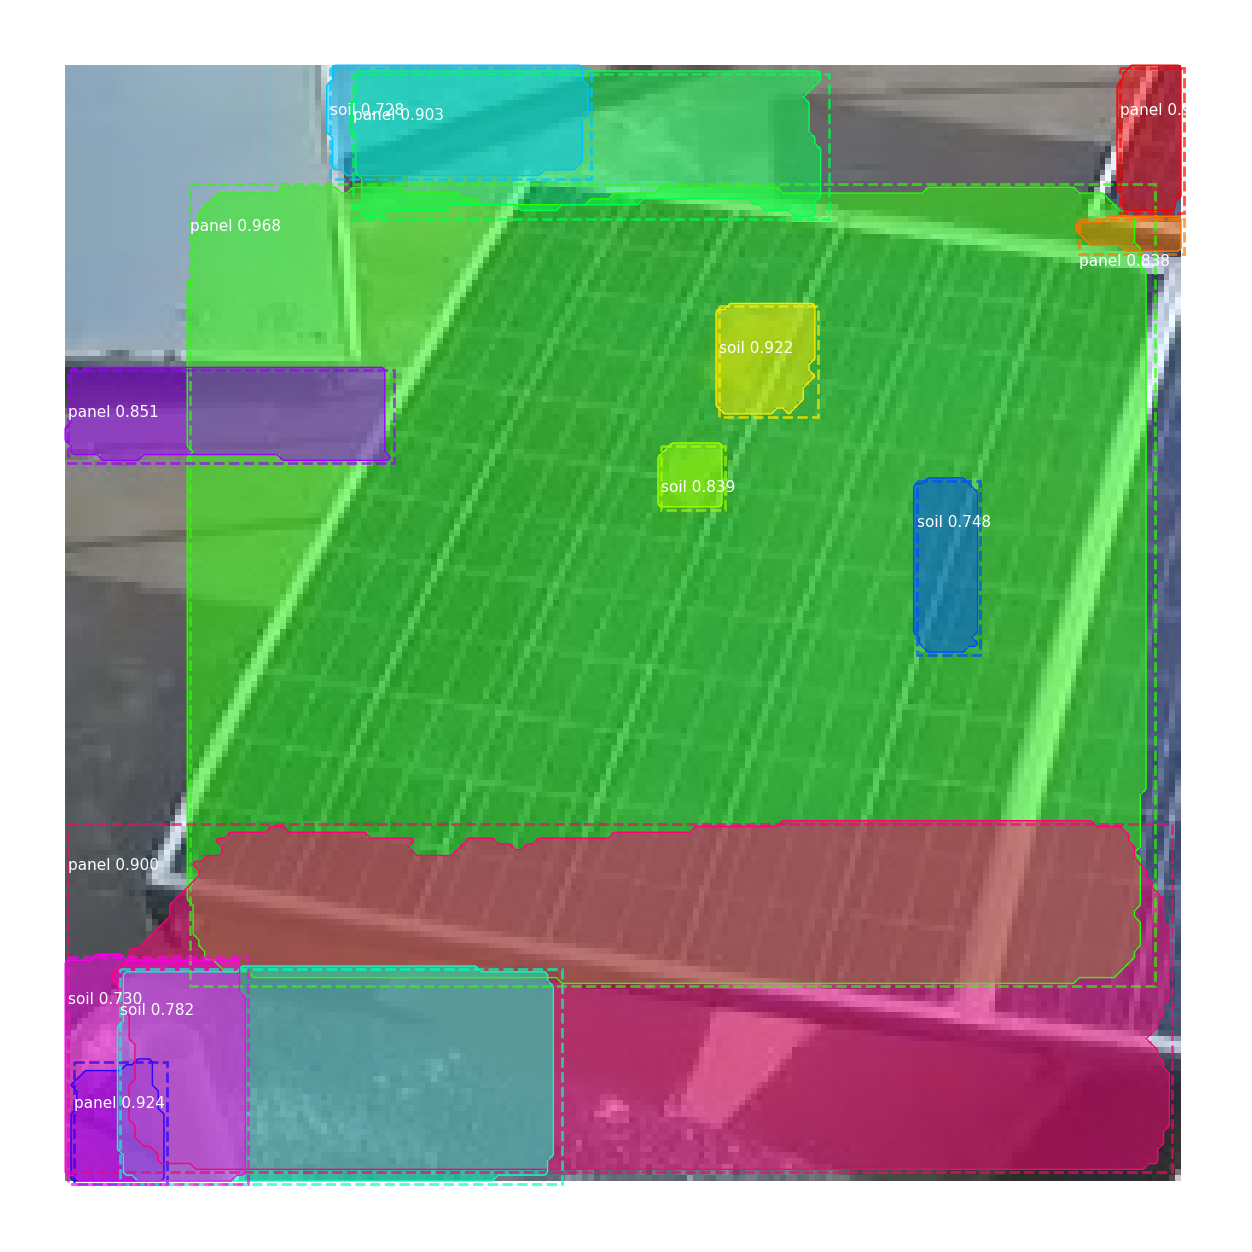

In [78]:
# Load a random image from the images folder
file_names = next(os.walk('/Users/peterbitman/Desktop/Mask-RCNN_TF2.14.0/RCNN_Masks/test/images'))[2]
image = skimage.io.imread(os.path.join('/Users/peterbitman/Desktop/Mask-RCNN_TF2.14.0/RCNN_Masks/test/images', random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            class_names, r['scores'])

In [92]:
r['rois']

array([[ 20,  21, 158, 187],
       [171,   1, 192,  17],
       [ 41, 112,  60, 129],
       [  0, 181,  25, 192],
       [  1,  49,  26, 131],
       [130,   0, 190, 190],
       [ 52,   0,  68,  56],
       [ 65, 102,  76, 113],
       [ 26, 174,  32, 192],
       [155,   9, 192,  85],
       [ 71, 146, 101, 157],
       [153,   0, 192,  31],
       [  0,  45,  19,  90]], dtype=int32)

In [75]:
for key in r.keys():
    print(r[key].shape)

(12, 4)
(12,)
(12,)
(192, 192, 12)


In [80]:
# Filter indices where class_id is 1 and score is less than 0.9
filtered_indices = np.where((r['class_ids'] == 1) & (r['scores'] < 0.95))[0]

# Remove the filtered indices from the data
filtered_data = {
    'rois': np.delete(r['rois'], filtered_indices, axis=0),
    'class_ids': np.delete(r['class_ids'], filtered_indices),
    'scores': np.delete(r['scores'], filtered_indices),
    'masks': np.delete(r['masks'], filtered_indices, axis=2)
}

for key in filtered_data.keys():
    print(filtered_data[key].shape)


(7, 4)
(7,)
(7,)
(192, 192, 7)


In [71]:
r['masks']

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

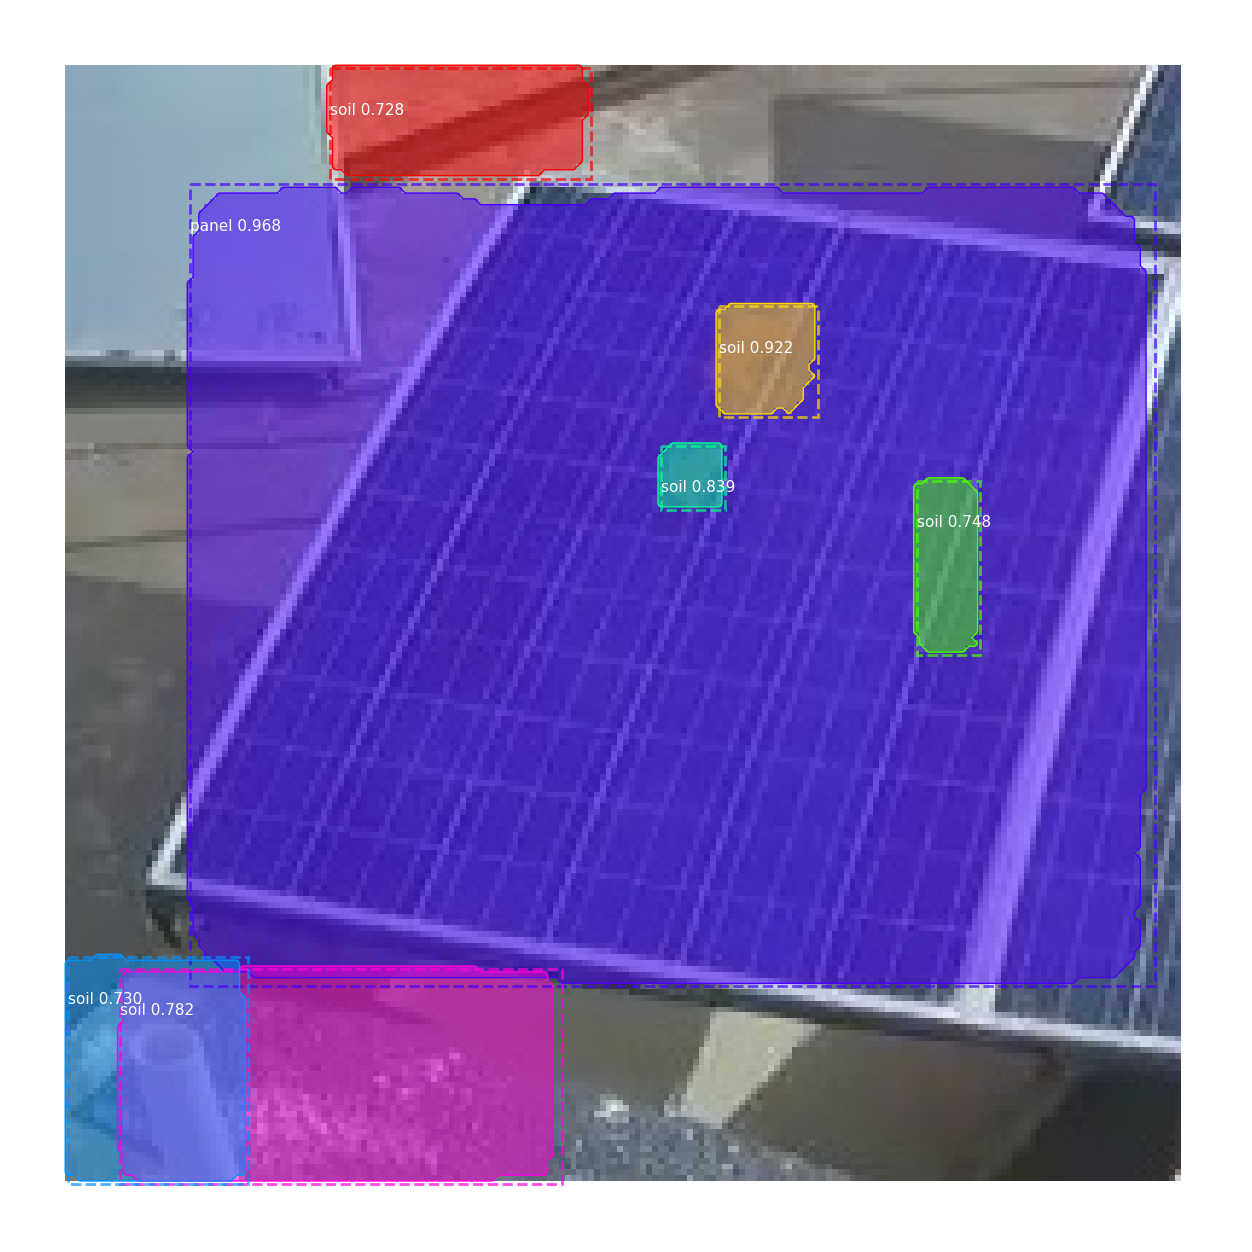

In [81]:

visualize.display_instances(image, filtered_data['rois'], filtered_data['masks'], filtered_data['class_ids'],
                            class_names, filtered_data['scores'])

In [ ]:
plt.savefig('foo.png', bbox_inches='tight')

In [23]:
results[0]

{'rois': array([[175,   2, 192,  19],
        [  0, 180,  26, 192],
        [ 27, 171,  34, 192],
        [ 27,  19, 160, 157],
        [131,   2, 187, 187],
        [ 34,  73, 147, 190],
        [128, 107, 160, 144],
        [162,  40, 170,  50],
        [ 59,   2,  73,  58],
        [129, 145, 142, 158]], dtype=int32),
 'class_ids': array([1, 1, 1, 1, 1, 2, 2, 2, 1, 2], dtype=int32),
 'scores': array([0.9198839 , 0.91894364, 0.90314347, 0.9005315 , 0.89590544,
        0.8873534 , 0.8132416 , 0.7924523 , 0.77271587, 0.71214443],
       dtype=float32),
 'masks': array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False,  True, False, ..., False, False, False],
         [False,  True, False, ..., False, False, False],
         [False,  True, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         